In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import griddata
import os
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
POT = 3.6e21

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

In [7]:
POT = 3.6e21

new_sample = np.array([])
new_points = np.array([])

recording = np.array([])

def extract_data():
    with open('./OGTPC1.txt', 'w') as r, open('./OGTPC1_pts.txt', 'w') as n:

        for m4, tr4 in zip(m_sample, mu_sample):

            path="OGTPC1_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4,tr4)
            
            if os.path.isfile('./output/'+path):
                data = awk.from_parquet("output/"+path)
                flag = data["secondary_types"]==22 * data["in_fiducial"]
                result = [m4,tr4,np.sum(np.transpose(data["event_weight"]*flag*POT)[1][1])*0.0006]
                result_string = ', '.join([f'{x:.16e}' for x in result])
                r.write(result_string+'\n')
                # f.write(f"{[m4,tr4,np.sum(np.transpose(data["event_weight"]*flag*POT)[1][1])*0.0006]}\n") 
            else:
                result_string = ', '.join([f'{x:.16e}' for x in [m4,tr4]])
                n.write(result_string+'\n')
            
    return "Extraction finished"

In [8]:
extract_data()

'Extraction finished'

In [9]:
def get_data(path): 
    
    x = []
    y = []
    z = []   
    
    with open(path,'r') as f:
        lines = f.readlines()
        for line in lines:
            i, ii, iii = line.strip().split(', ')
            x += [np.log10(float(i)*1000)]
            # convert d = mu/2
            y += [np.log10(float(ii)/2)]
            z += [np.log10(float(iii))]
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        
    return x, y, z

In [12]:
def read_coordinates(filename):
    coordinates = {}
    with open(filename, 'r') as file:
        for line in file:
            data = line.strip().split(', ')
            if len(data) >= 3:
                x, y, z = float(data[0]), float(data[1]), float(data[2])
                coordinates[(x, y)] = z
    return coordinates

def sum_z_coordinates(file_list, year):
    sum_coordinates = {}
    
    for filename in file_list:
        coords = read_coordinates(filename)
        for (x, y), z in coords.items():
            if (x, y) in sum_coordinates:
                sum_coordinates[(x, y)] += z*year/10
            else:
                sum_coordinates[(x, y)] = z*year/10
    
    return sum_coordinates

def write_sum_file(sum_coordinates, output_file):
    with open(output_file, 'w') as file:
        for (x, y), z in sum_coordinates.items():
            # file.write(f"{x} {y} {z}\n")
            file.write(f'{x:.16e}'+', '+f'{y:.16e}'+', '+f'{z:.16e}'+'\n')

# List of input files
input_files = ['./TPC1.txt', './TPC2.txt', './TPC3.txt', './TPC4.txt', './TPC5.txt']
OG_input_files = ['./OGTPC1.txt', './OGTPC2.txt', './OGTPC3.txt']

# Sum z-coordinates
result = sum_z_coordinates(OG_input_files,3)

# Write the result to sum.txt
write_sum_file(result, 'OG_sum_y3.txt')

print("Processing complete. Results written to sum.txt")

Processing complete. Results written to sum.txt


/tmp/ipykernel_2775136/1811305995.py:45: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, collection in enumerate(contour_line.collections):


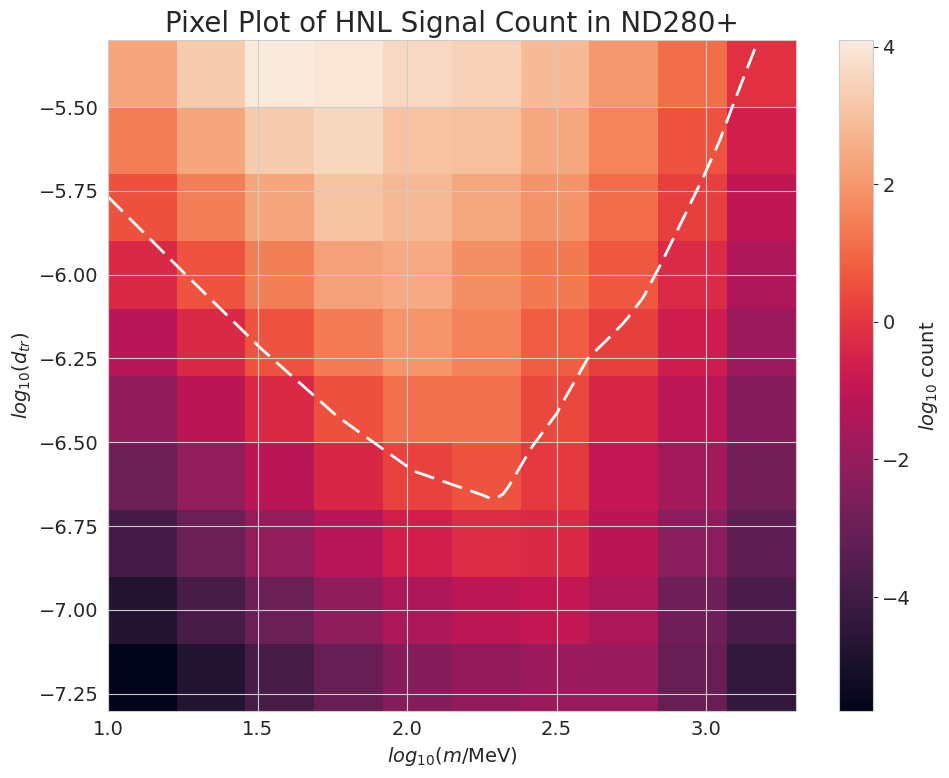

In [15]:
plt.rcParams.update({'font.size': 14})

def create_pixel_plot(x, y, z):
         
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)

    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto')  # Set aspect to 'auto'
    plt.colorbar(im, label='$log_{10}$ count')
    ax.set_xlabel('$log_{10}(m$/MeV$)$', fontsize = 14)
    ax.set_ylabel('$log_{10}( d_{tr} )$', fontsize = 14)
    ax.set_title('Pixel Plot of HNL Signal Count in ND280+', fontsize = 20)
    
    # Create x-y grid for interpolation
    xi = np.linspace(x_unique.min(), x_unique.max(), 100)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='linear')
    contour_line = plt.contour(Xi, Yi, Zi, levels=[np.log10(np.log(1/0.05))], colors='white', linestyles='dashed', linewidths=2)
    # plt.clabel(contour_line, inline=True, fontsize=10, fmt='%1.1f')

    # Open a file to write the contour data
    with open('OG_contour_data_y3.txt', 'w') as f:
        for i, collection in enumerate(contour_line.collections):
            level = [np.log10(np.log(1/0.05))]
            for path in collection.get_paths():
                vertices = path.vertices
                f.write(f"Contour Level: {level}\n")
                for x, y in vertices:
                    f.write(f"{x:.6f}\t{y:.6f}\n")
                f.write("\n")
                
    # ax = plt.gca()
    # ax.set_xlim([1.5, 3.0])
    # ax.set_ylim([-7.0, -6.0])
                
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xscale('linear')
    plt.yscale('linear')
    
    # Adjust the plot to fill the figure
    plt.tight_layout()
    
    plt.show()
    
x, y, z = get_data('./OG_sum_y3.txt')
create_pixel_plot(x, y, z)

m_sample_new

<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2077087/227310620.py:30: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$log_{10}( \mu_{tr} )$', fontsize = 14)
/tmp/ipykernel_2077087/227310620.py:45: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, collection in enumerate(contour_line.collections):


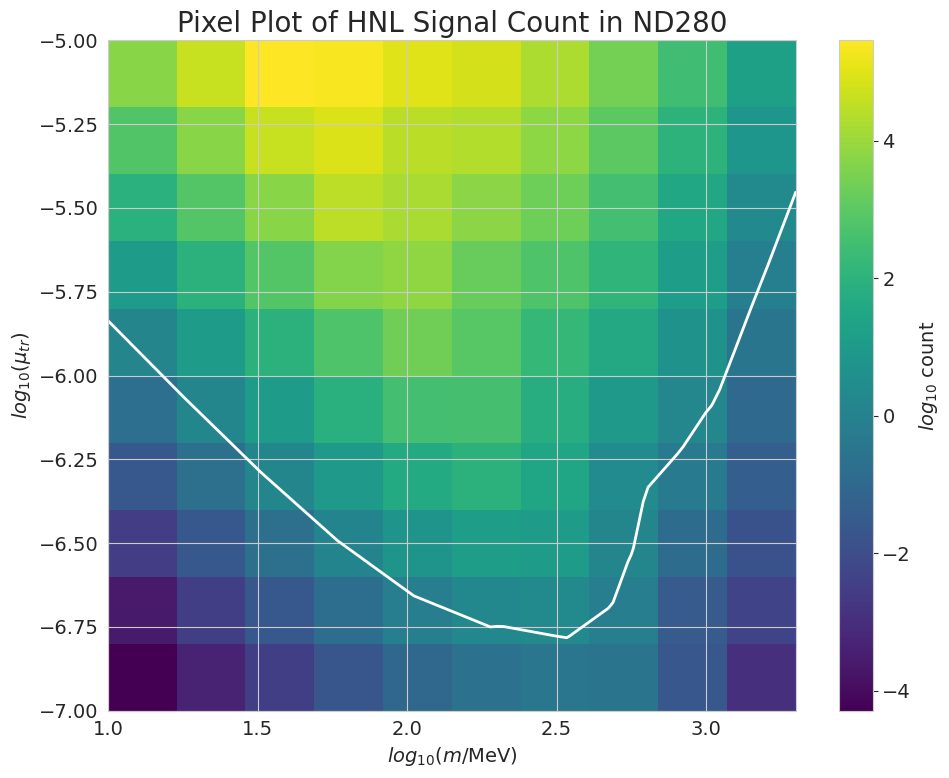

In [19]:
plt.rcParams.update({'font.size': 14})

def create_pixel_plot_OG(x, y, z):
         
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)

    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto', cmap='viridis')  # Set aspect to 'auto'
    plt.colorbar(im, label='$log_{10}$ count')
    ax.set_xlabel('$log_{10}(m$/MeV$)$', fontsize = 14)
    ax.set_ylabel('$log_{10}( \mu_{tr} )$', fontsize = 14)
    ax.set_title('Pixel Plot of HNL Signal Count in ND280', fontsize = 20)
    
    # Create x-y grid for interpolation
    xi = np.linspace(x_unique.min(), x_unique.max(), 100)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='linear')
    contour_line = plt.contour(Xi, Yi, Zi, levels=[np.log10(2.3)], colors='white', linestyles='solid', linewidths=2)
    # plt.clabel(contour_line, inline=True, fontsize=10, fmt='%1.1f')

    # Open a file to write the contour data
    with open('OG_contour_data_1E5_y3.txt', 'w') as f:
        for i, collection in enumerate(contour_line.collections):
            level = [np.log10(np.log(1/0.05))]
            for path in collection.get_paths():
                vertices = path.vertices
                f.write(f"Contour Level: {level}\n")
                for x, y in vertices:
                    f.write(f"{x:.6f}\t{y:.6f}\n")
                f.write("\n")
                
    # ax = plt.gca()
    # ax.set_xlim([1.5, 3.0])
    # ax.set_ylim([-7.0, -6.0])
                
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xscale('linear')
    plt.yscale('linear')
    
    # Adjust the plot to fill the figure
    plt.tight_layout()
    
    plt.show()

x, y, z = get_data('./OG_sum_y3.txt')
create_pixel_plot_OG(x, y, z)

In [5]:
i=66
m4, tr4 = m_sample[i], mu_sample[i]

path="TPC2_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4,tr4)

if os.path.isfile('./output/'+path):
    data = awk.from_parquet("output/"+path)

dist = []

for pts in data['vertex']:
    [a, b]= pts
    dist += [np.linalg.norm(a-b)]

# Load the NumPy array (if saved in a file)
# data = np.load('path_to_your_array.npy')

# If the array is already in memory, use it directly:

logdist = np.log10(dist)

In [7]:
weight = data['event_weight']

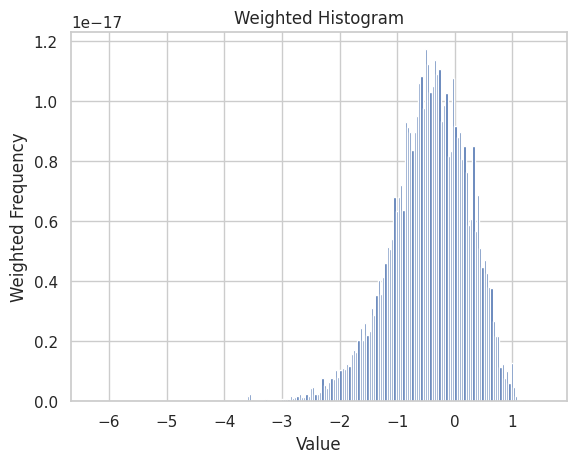

In [20]:
hist, bin_edges = np.histogram(logdist, weights=weight, bins=200)   
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align="edge")
plt.xlabel('Value')
plt.ylabel('Weighted Frequency')
plt.title('Weighted Histogram')
plt.show()

In [15]:
def weighted_median(data, weights):
    """Calculate the weighted median of a list of values."""
    data, weights = np.array(data), np.array(weights)
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

In [16]:
weighted_median(dist,weight)

0.39285911446260074

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2664183/1558156408.py:33: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$m=%2.2e, \mu_{tr}=%2.2e$'%(m4,tr4), fontsize=20)
/tmp/ipykernel_2664183/1558156408.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mathcal{N}$ decay distance ($log_{10}(d/m)$)', fontsize=14)


Maximum value: 1.5543517232434894
Minimum value: -6.265543038398128
Weighted Median: -0.4057631666252467


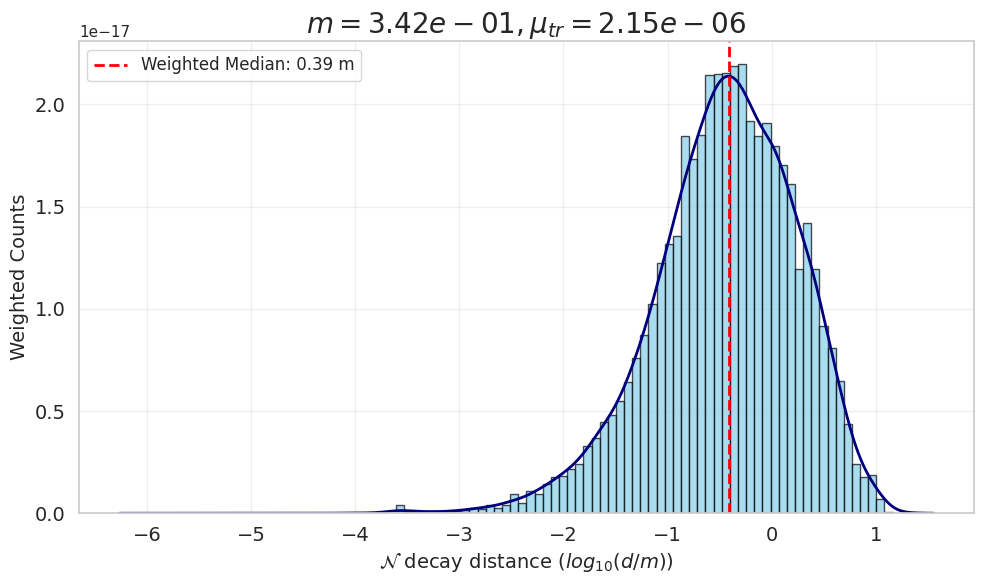

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Convert inputs to numpy arrays if they aren't already
logdist = np.asarray(logdist)
weight = np.asarray(weight)

# Print out the max and minimum values
logdist_max = np.max(logdist)
logdist_min = np.min(logdist)
weighted_med = weighted_median(logdist, weight)  # Assuming you've defined this function
print(f"Maximum value: {logdist_max}")
print(f"Minimum value: {logdist_min}")
print(f"Weighted Median: {weighted_med}")

# Create the weighted histogram
plt.figure(figsize=(10, 6))

# Calculate the weighted histogram
hist, bin_edges = np.histogram(logdist, bins=100, weights=weight)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.bar(bin_centers, hist, width=np.diff(bin_edges), alpha=0.7, color='skyblue', edgecolor='black')

# Calculate and plot the KDE
kde = stats.gaussian_kde(logdist, weights=weight)
x_range = np.linspace(logdist_min, logdist_max, 1000)
plt.plot(x_range, kde(x_range) * np.sum(hist) * np.diff(bin_edges)[0], color='navy', linewidth=2)

# Customize the plot
plt.title('$m=%2.2e, \mu_{tr}=%2.2e$'%(m4,tr4), fontsize=20)
plt.xlabel('$\mathcal{N}$ decay distance ($log_{10}(d/m)$)', fontsize=14)
plt.ylabel("Weighted Counts", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

print_weighted_med = np.power(10, weighted_med)

# Add vertical line for weighted median
plt.axvline(weighted_med, color='red', linestyle='dashed', linewidth=2, label=f'Weighted Median: {print_weighted_med:.2f} m')

print_weighted_med = np.power(10, weighted_med)
# Add text annotation for the median value
# plt.text(print_weighted_med, plt.ylim()[1], f'{print_weighted_med:.2e}', 
#          horizontalalignment='center', verticalalignment='bottom',
#          fontsize=12, color='red', rotation=0)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
POT = 3.6e21

weighted_med = {}

for m4, tr4 in zip(m_sample, mu_sample):

    path="OGTPC2_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4,tr4)
    
    if os.path.isfile('./output/'+path):
        data = awk.from_parquet("output/"+path)
    
    weight = data['event_weight']
    dist = []

    for pts in data['vertex']:
        [a, b]= pts
        dist += [np.linalg.norm(a-b)]
        
    weighted_med[(m4, tr4)] = weighted_median(dist, weight)
    
def extract_xyz(data_dict):
    # Extract the keys and values
    keys = np.array(list(data_dict.keys()))
    values = np.array(list(data_dict.values()))
    
    # Split the keys into x and y
    x = keys[:, 0]
    y = keys[:, 1]
    
    # The values are already z
    z = values
    
    return x, y, z

x, y, z = extract_xyz(weighted_med)



KeyboardInterrupt: 

In [ ]:
plt.rcParams.update({'font.size': 14})

def distance_pixel_plot(x, y, z):
         
    # Sort the points based on x and y coordinates
    sorted_indices = np.lexsort((y, x))
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    z_sorted = z[sorted_indices]

    # Get unique x and y values
    x_unique = np.unique(x_sorted)
    y_unique = np.unique(y_sorted)

    # Create a 2D grid for the z values
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)

    # Fill the grid with z values
    for i, (xi, yi, zi) in enumerate(zip(x_sorted, y_sorted, z_sorted)):
        x_idx = np.where(x_unique == xi)[0][0]
        y_idx = np.where(y_unique == yi)[0][0]
        z_grid[y_idx, x_idx] = zi

    # Create the pixel plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto')  # Set aspect to 'auto'
    plt.colorbar(im, label='$log_{10}$ count')
    ax.set_xlabel('$log_{10}(m$/MeV$)$', fontsize = 14)
    ax.set_ylabel('$log_{10}( \mu_{tr} )$', fontsize = 14)
    ax.set_title('Pixel Plot of HNL Signal Count in ND280+', fontsize = 20)
    
    # Create x-y grid for interpolation
    xi = np.linspace(x_unique.min(), x_unique.max(), 100)
    yi = np.linspace(y_unique.min(), y_unique.max(), 100)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate the data onto the grid
    Zi = griddata((x_sorted, y_sorted), z_sorted, (Xi, Yi), method='linear')
    contour_line = plt.contour(Xi, Yi, Zi, levels=[np.log10(2.3)], colors='white', linestyles='dashed', linewidths=2)
    # plt.clabel(contour_line, inline=True, fontsize=10, fmt='%1.1f')

    # Open a file to write the contour data
    with open('contour_data_1E5_y5e-1.txt', 'w') as f:
        for i, collection in enumerate(contour_line.collections):
            level = [np.log10(np.log(1/0.05))]
            for path in collection.get_paths():
                vertices = path.vertices
                f.write(f"Contour Level: {level}\n")
                for x, y in vertices:
                    f.write(f"{x:.6f}\t{y:.6f}\n")
                f.write("\n")
                
    # ax = plt.gca()
    # ax.set_xlim([1.5, 3.0])
    # ax.set_ylim([-7.0, -6.0])
                
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xscale('linear')
    plt.yscale('linear')
    
    # Adjust the plot to fill the figure
    plt.tight_layout()
    
    plt.show()
    
distance_pixel_plot(x, y, z)

In [23]:
# Kinematic distributions

def plot_kinematics(data,POT,Emax,axis,ylim_E=None,ylim_C=None,nbins=30,savestr=None):
    
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    # ax[0].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    # ax[1].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    
    # initial nu
    nu_flag = data["primary_type"]==14
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

    # N
    N_flag = data["primary_type"]==5914
    N_momenta = np.squeeze(data["primary_momentum"][N_flag])

    # gamma
    gamma_flag = data["secondary_types"]==22
    gamma_momenta = data["secondary_momenta"][gamma_flag]
    # mask out entries that are not gamma
    gamma_momenta = awk.mask(gamma_momenta, awk.num(gamma_momenta,axis=2)>0)
    gamma_momenta = np.squeeze(gamma_momenta[~awk.is_none(gamma_momenta,axis=1)])
    
    # nu out
    nuout_flag = data["secondary_types"]==5910
    nuout_momenta = data["secondary_momenta"][nuout_flag]
    # mask out entries that are not nuout
    nuout_momenta = awk.mask(nuout_momenta, awk.num(nuout_momenta,axis=2)>0)
    nuout_momenta = np.squeeze(nuout_momenta[~awk.is_none(nuout_momenta,axis=1)])

    kwargs = {"bins":np.linspace(0,Emax,nbins),
              "weights":data["event_weight"]*POT}

    # Energy
    n,bins = np.histogram(nu_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(n,n[-1]),where="post",label=r"Initial $\nu$")
    _n,bins = np.histogram(N_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",label=r"Upscattered $\mathcal{N}$")
    _n,bins = np.histogram(gamma_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\gamma$")
    _n,bins = np.histogram(nuout_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\nu$")
    
    # Angle
    def CosTheta(momenta):
        return momenta[:,axis]/np.linalg.norm(momenta[:,1:],axis=-1)
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    m,bins = np.histogram(CosTheta(nu_momenta),**kwargs)
    ax[1].step(bins,np.append(m,m[-1]),where="post",label=r"Initial $\nu$")
    _n,bins = np.histogram(CosTheta(N_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",label=r"Upscattered $\mathcal{N}$")
    _n,bins = np.histogram(CosTheta(gamma_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\gamma$")
    _n,bins = np.histogram(CosTheta(nuout_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",label=r"Outgoing $\nu$")
    
    # fiducial events
    
    kwargs["weights"]=np.squeeze(kwargs["weights"]*fid_flag)
    kwargs["bins"] = np.linspace(0,Emax,nbins)
    
    # Energy [fiducial]
    _n,bins = np.histogram(nu_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(N_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(gamma_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(nuout_momenta[:,0],**kwargs)
    ax[0].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    
    kwargs["bins"] = np.linspace(-1,1,nbins)
    
    _n,bins = np.histogram(CosTheta(nu_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(CosTheta(N_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(CosTheta(gamma_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    _n,bins = np.histogram(CosTheta(nuout_momenta),**kwargs)
    ax[1].step(bins,np.append(_n,_n[-1]),where="post",ls="--")
    
    ax[0].plot([],[],label="All Events",color="black")
    ax[0].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[0].legend(loc="upper right",ncol=2)
    ax[0].semilogy()
    ax[0].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[0].set_xlim(0,Emax)
    if ylim_E is not None:
        ax[0].set_ylim(ylim_E)
    
    ax[1].plot([],[],label="All Events",color="black")
    ax[1].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[1].legend(loc="upper left",ncol=2)
    ax[1].semilogy()
    ax[1].set_xlabel(r"$\cos \theta$")
    ax[1].set_ylabel("Event Rate in %2.2e POT"%POT)
    ax[1].set_xlim(-1,1)
    if ylim_C is not None:
        ax[1].set_ylim(ylim_C)
        
    plt.tight_layout()
    if savestr is not None:
        plt.savefig(savestr+"_kinematics.pdf",dpi=100)
    
    plt.show()
    
def position_plot(x,y,bins,labelx,labely,title):
    plt.hist2d(x,y,bins=bins,norm=LogNorm())
    # c = plt.colorbar()
    # c.set_label("Number of Generated Events")
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.text(0.96*bins[0][1],0.90*bins[1][-4],
             title,
             fontsize=16,
             bbox=dict(boxstyle="round",
                       ec="black",
                       fc="white")
            )
    plt.tight_layout()
    
    

def plot_positions(data,range1,range2,slice1="x",slice2="y",savestr=None):
    
    dec_flag = data["primary_type"]==5914
    fid_flag = data["in_fiducial"][dec_flag]
    
    fid_vertex = data["vertex"][data["in_fiducial"]][fid_flag]
    # mask out entries that are not fiducial
    fid_vertex = awk.mask(fid_vertex, awk.num(fid_vertex,axis=1)>0)
    fid_vertex = np.array(np.squeeze(fid_vertex[~awk.is_none(fid_vertex,axis=0)]))
    
    axis1 = {"x":0,"y":1,"z":2}[slice1]
    axis2 = {"x":0,"y":1,"z":2}[slice2]
    
    bins = (np.linspace(range1[0],range1[1],80),
            np.linspace(range2[0],range2[1],80))
    
    # for target in np.unique(np.array(data["target_type"][~dec_flag])):
    #     target_flag = np.squeeze((data["target_type"]==target)[~dec_flag])
    #     data_reduced = data[target_flag]
    #     label = target[target.find("."):target.find("Nucleus")]
    #     plt.scatter(np.array(data_reduced["vertex"][~dec_flag[target_flag]][:,0,axis1]),
    #                 np.array(data_reduced["vertex"][~dec_flag[target_flag]][:,0,axis2]),
    #                 alpha=0.5,label=label)
    # plt.xlim(bins[0][0],bins[0][-1])
    # plt.ylim(bins[1][0],bins[1][-1])
    # plt.legend(ncol=2)
    # plt.show()
    
    position_plot(np.array(data["vertex"][~dec_flag][:,0,axis1]),
                  np.array(data["vertex"][~dec_flag][:,0,axis2]),
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Upscattering Vertex")
    # if savestr is not None:
    #     plt.savefig(savestr+"_upscattering_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()
    
    position_plot(np.array(data["vertex"][dec_flag][:,0,axis1]),
                  np.array(data["vertex"][dec_flag][:,0,axis2]),
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Decay Vertex")
    plt.text( -9.5, -4.5, '$m=$%2.2e, $\mu_{tr}=$%2.2e'%(m4, tr4), color='black', fontsize=14, backgroundcolor='none')

    plt.text( -9.5, -3.8, 'ND280', color='black', fontsize=20, backgroundcolor='none')    
    # if savestr is not None:
    #     plt.savefig(savestr+"_decay_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()
    
    position_plot(fid_vertex[:,axis1],
                  fid_vertex[:,axis2],
                  bins,"%s [m]"%slice1,"%s [m]"%slice2,"Decay Vertex (Fiducial)")
    
    # if savestr is not None:
    #     plt.savefig(savestr+"_fiducial_decay_vertex_%s%s.pdf"%(slice1,slice2),dpi=100)
    plt.show()

<>:171: SyntaxWarning: invalid escape sequence '\m'
<>:171: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_389619/285789943.py:171: SyntaxWarning: invalid escape sequence '\m'
  plt.text( -9.5, -4.5, '$m=$%2.2e, $\mu_{tr}=$%2.2e'%(m4, tr4), color='black', fontsize=14, backgroundcolor='none')


OGTPC1_Dipole_M5.85e-02_mu4.64e-07_example.parquet


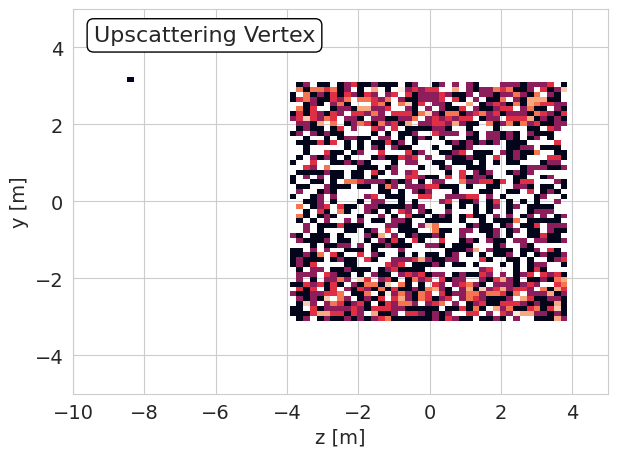

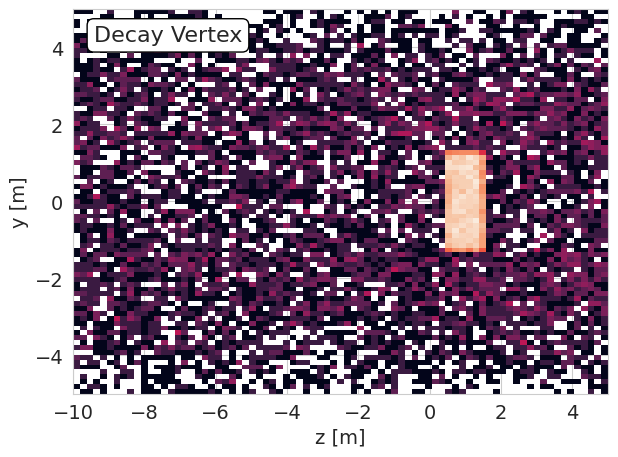

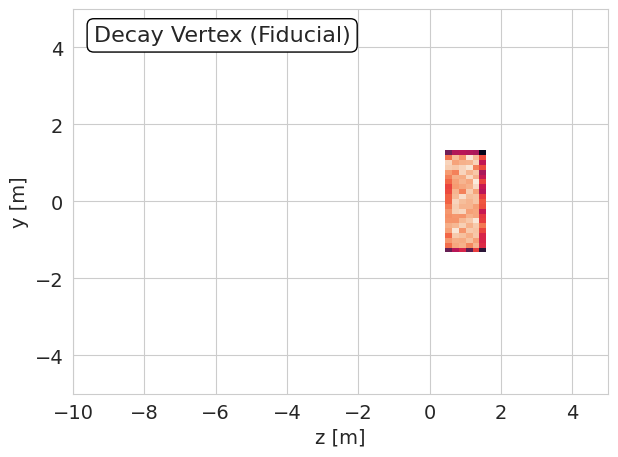

OGTPC2_Dipole_M5.85e-02_mu4.64e-07_example.parquet


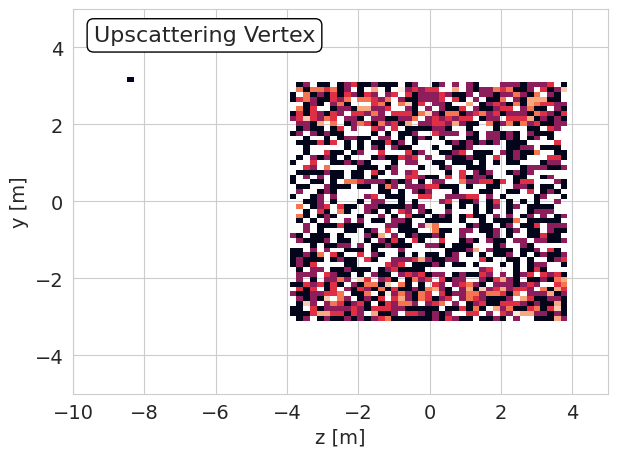

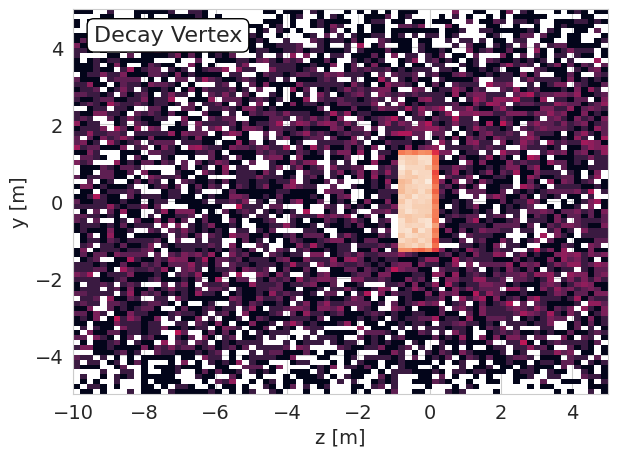

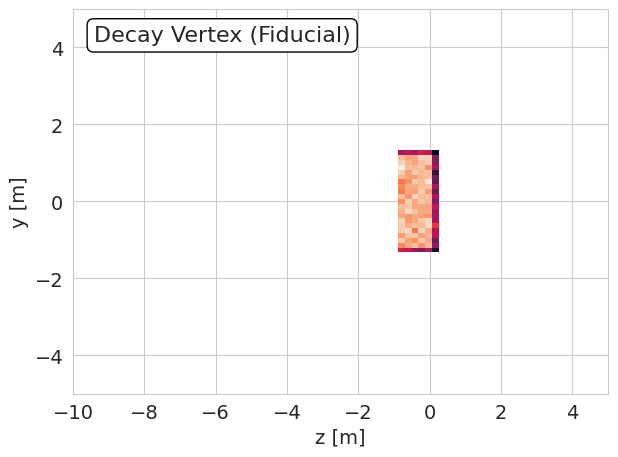

OGTPC3_Dipole_M5.85e-02_mu4.64e-07_example.parquet


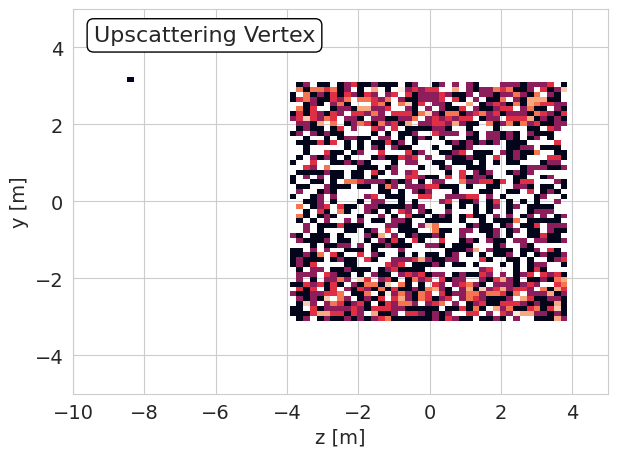

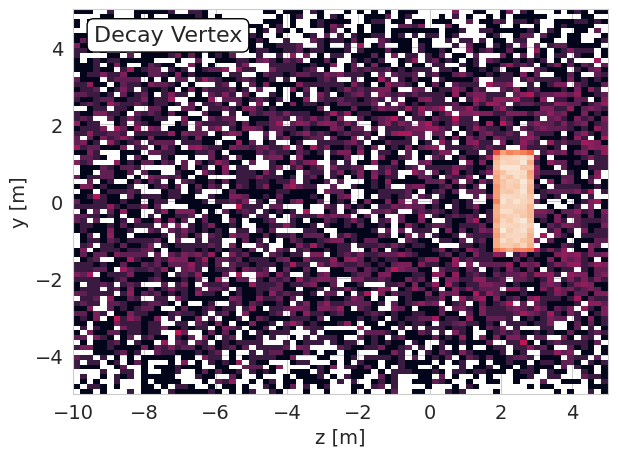

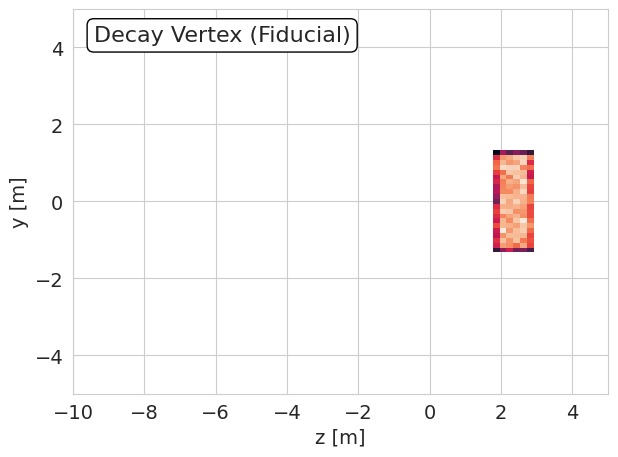

In [18]:
subpa = ['OGTPC1','OGTPC2','OGTPC3']

plt.rcParams.update({'font.size':14})
i=33
m4, tr4 = m_sample[i], mu_sample[i]

for s in subpa:
    path=s+"_Dipole_M%2.2e_mu%2.2e_example.parquet"%(m4, tr4)
    if os.path.isfile('./output/'+path):
        print(path)
        data = awk.from_parquet("output/"+path)

    Emax = 5
    axis = 3
    ylim_E = 1e6; ylim_C = 1e6
    xrange = [-5,5]; yrange = [-5,5]; zrange = [-10,5]

    plot_positions(data,zrange,yrange,"z","y",savestr="figures/%s"%'nd280')
    
    
# plt.text( -9.5, -4.5, '$m=$%2.2e, $\mu_{tr}=$%2.2e'%(m4, tr4), color='black', fontsize=14, backgroundcolor='none')
# plt.text( -9.5, -3.5, 'ND280', color='black', fontsize=20, backgroundcolor='none')

plt.show()

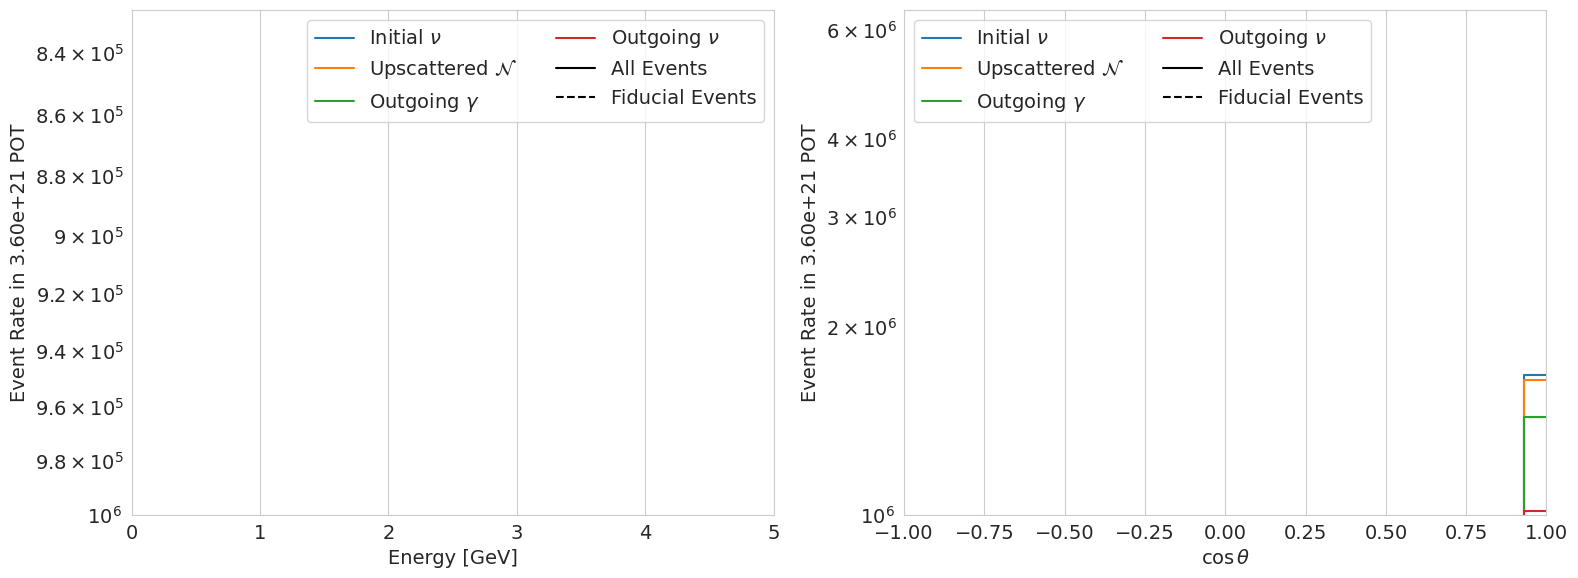

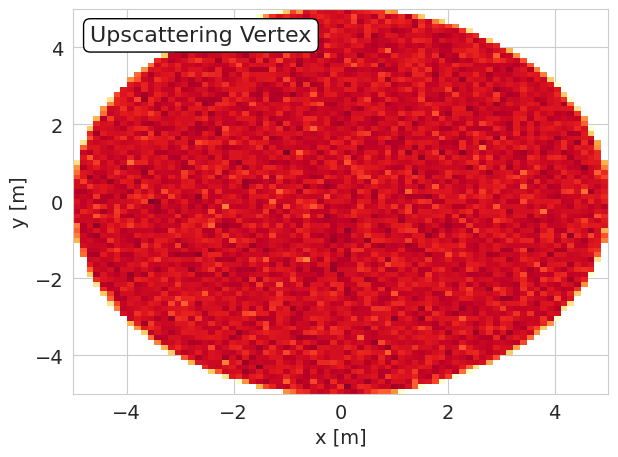

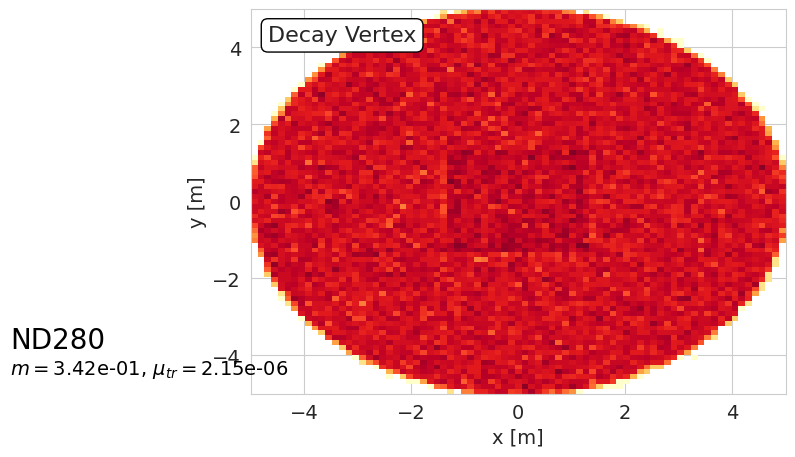

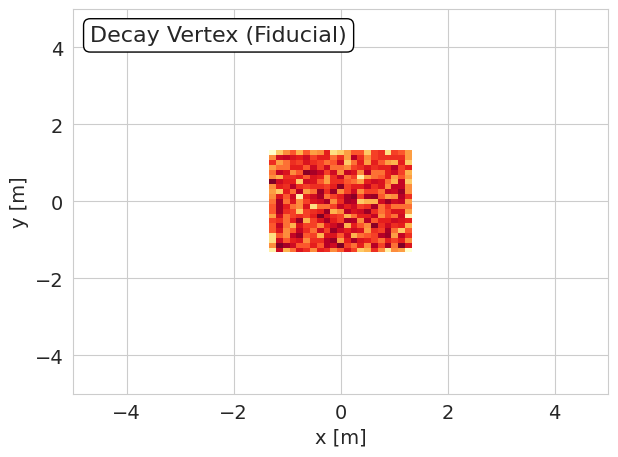

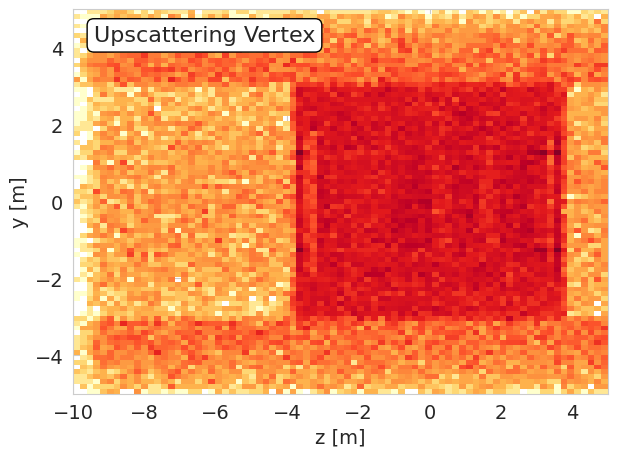

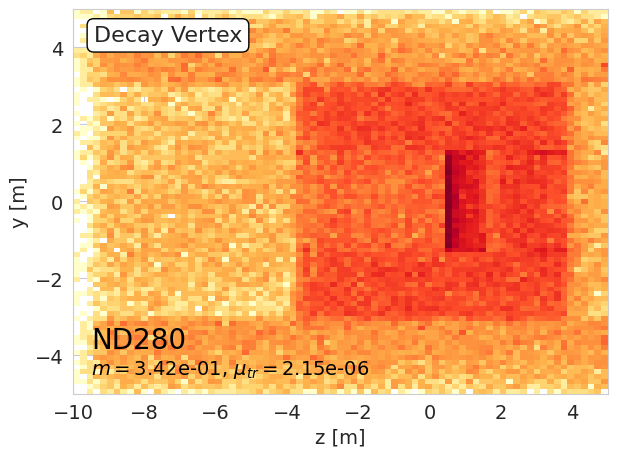

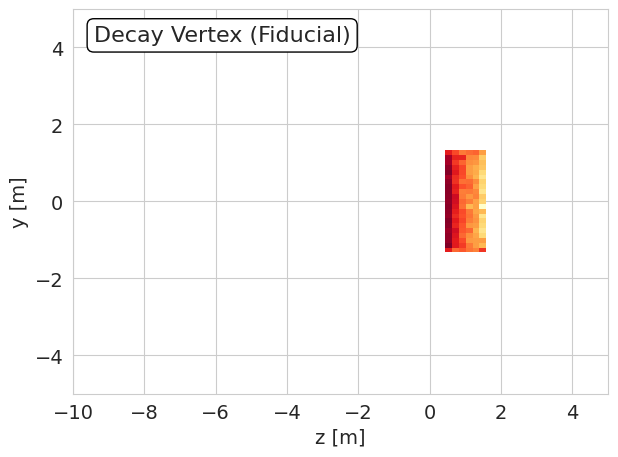

In [25]:
i=66
plt.rcParams.update({'font.size':14,'image.cmap': 'YlOrRd'})

m4, tr4 = m_sample[i], mu_sample[i]

path="%s_Dipole_M%2.2e_mu%2.2e_example.parquet"%('OGTPC1',m4,tr4)

if os.path.isfile('./output/'+path):
    data = awk.from_parquet("output/"+path)

k='OGTPC1'
Emax = 5
axis = 3
ylim_E = 1e6; ylim_C = 1e6
xrange = [-5,5]; yrange = [-5,5]; zrange = [-10,5]
plot_kinematics(data,POT,Emax,axis,ylim_E,ylim_C,savestr="figures/%s"%k)
plot_positions(data,xrange,yrange,savestr="figures/%s"%k)
plot_positions(data,zrange,yrange,"z","y",savestr="figures/%s"%k)